# Invoke Bedrock model for code generation

> *If you see errors, you may need to be allow-listed for the Bedrock models used by this notebook*

> *This notebook should work well with the **`Data Science 3.0`** kernel in SageMaker Studio*

## Introduction

In this notebook we show you how to use a LLM to generate code based on the text prompt.

We will use Bedrock's Claude v2 using the Boto3 API. 

The prompt used in this example is called a zero-shot prompt because we are not providing any examples of text other than the prompt.

**Note:** *This notebook can be run within or outside of AWS environment.*

#### Context
To demonstrate the code generation capability of Amazon Bedrock, we will explore the use of Boto3 client to communicate with Amazon Bedrock API. We will demonstrate different configurations available as well as how simple input can lead to desired outputs.

#### Pattern
We will simply provide the Amazon Bedrock API with an input consisting of a task, an instruction and an input for the model under the hood to generate an output without providing any additional example. The purpose here is to demonstrate how the powerful LLMs easily understand the task at hand and generate compelling outputs.

![](./images/bedrock-code-gen.png)

#### Use case
To demonstrate the generation capability of models in Amazon Bedrock, let's take the use case of code generation.

#### Persona

You are Moe, a Data Analyst, at AnyCompany. The company wants to understand its sales performance for different products for different products over the past year. You have been provided a dataset named sales.csv. The dataset contains the following columns:

- Date (YYYY-MM-DD) format
- Product_ID (unique identifer for each product)
- Price (price at which each product was sold)

#### Implementation
To fulfill this use case, in this notebook we will show how to generate code for a given prompt. We will use the Anthropic Claude v2 using the Amazon Bedrock API with Boto3 client. 

## Setup

In [2]:
%pip install --no-build-isolation --force-reinstall \
    "boto3>=1.28.57" \
    "awscli>=1.29.57" \
    "botocore>=1.31.57"

%pip install --quiet langchain==0.0.309

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Obtaining dependency information for boto3>=1.28.57 from https://files.pythonhosted.org/packages/45/78/e95de33d8850429f6740763eb2d5350c02fd39e916f2ddb69fe649d25125/boto3-1.29.6-py3-none-any.whl.metadata
  Obtaining dependency information for awscli>=1.29.57 from https://files.pythonhosted.org/packages/c9/fa/708f561f2ec441b9e9f6e9780a0519a7922a8e1f02c92671454983ff44c3/awscli-1.30.6-py3-none-any.whl.metadata
  Obtaining dependency information for botocore>=1.31.57 from https://files.pythonhosted.org/packages/e4/dd/a6c7154d4f045599ce2df9199c01a8c2650c45ae74ad63f69547a500cc1c/botocore-1.32.6-py3-none-any.whl.metadata
  Obtaining dependency information for s3transfer<0.8.0,>=0.7.0 from https://files.pythonhosted.org/packages/5a/4b/fec9ce18f8874a96c5061422625ba86c3ee1e6587ccd92ff9f5bf7bd91b2/s3transfer-0.7.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.2/548.2 kB 75.1 MB/s eta 0:00:00
  Ob

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# To execute the generated code in this notebook
%pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
#### Un comment the following lines to run from your local environment outside of the AWS account with Bedrock access

#import os
#os.environ['BEDROCK_ASSUME_ROLE'] = '<YOUR_VALUES>'
#os.environ['AWS_PROFILE'] = '<YOUR_VALUES>'

In [6]:
import boto3
import json 

bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

## Code Generation

Following on the use case explained above, let's prepare an input for  the Amazon Bedrock service to generate python program for our use-case.

#### Lab setup - create sample sales.csv data for this lab.



In [7]:
# create sales.csv file
import csv

data = [
    ["date", "product_id", "price", "units_sold"],
    ["2023-01-01", "P001", 50, 20],
    ["2023-01-02", "P002", 60, 15],
    ["2023-01-03", "P001", 50, 18],
    ["2023-01-04", "P003", 70, 30],
    ["2023-01-05", "P001", 50, 25],
    ["2023-01-06", "P002", 60, 22],
    ["2023-01-07", "P003", 70, 24],
    ["2023-01-08", "P001", 50, 28],
    ["2023-01-09", "P002", 60, 17],
    ["2023-01-10", "P003", 70, 29],
    ["2023-02-11", "P001", 50, 23],
    ["2023-02-12", "P002", 60, 19],
    ["2023-02-13", "P001", 50, 21],
    ["2023-02-14", "P003", 70, 31],
    ["2023-03-15", "P001", 50, 26],
    ["2023-03-16", "P002", 60, 20],
    ["2023-03-17", "P003", 70, 33],
    ["2023-04-18", "P001", 50, 27],
    ["2023-04-19", "P002", 60, 18],
    ["2023-04-20", "P003", 70, 32],
    ["2023-04-21", "P001", 50, 22],
    ["2023-04-22", "P002", 60, 16],
    ["2023-04-23", "P003", 70, 34],
    ["2023-05-24", "P001", 50, 24],
    ["2023-05-25", "P002", 60, 21]
]

# Write data to sales.csv
with open('sales.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(data)

print("sales.csv has been created!")

sales.csv has been created!


#### Analyzing sales with Amazon Bedrock generated Python program

In [8]:
# Create the prompt
# Analyzing sales

prompt_data = """

Human: You have a CSV, sales.csv, with columns:
- date (YYYY-MM-DD)
- product_id
- price
- units_sold

Create a python program to analyze the sales data from a CSV file. The program should be able to read the data, and determine below:

- Total revenue for the year
- The product with the highest revenue
- The date with the highest revenue
- Visualize monthly sales using a bar chart

Ensure the code is syntactically correct, bug-free, optimized, not span multiple lines unnessarily, and prefer to use standard libraries. Return only python code without any surrounding text, explanation or context.

Assistant:
"""

Let's start by using the Anthropic Claude V2 model.

In [9]:
# Claude - Body Syntex
body = json.dumps({
                    "prompt": prompt_data,
                    "max_tokens_to_sample":4096,
                    "temperature":0.5,
                    "top_k":250,
                    "top_p":0.5,
                    "stop_sequences": ["\n\nHuman:"]
                  }) 

#### Invoke the Anthropic Claude v2 model

In [10]:
modelId = 'anthropic.claude-v2' # change this to use a different version from the model provider
accept = 'application/json'
contentType = 'application/json'

response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response_body = json.loads(response.get('body').read())

print(response_body.get('completion'))

 Here is the Python code to analyze sales data from a CSV file:

```python
import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue = 0
max_revenue = 0
max_revenue_product = None
max_revenue_date = None
monthly_sales = defaultdict(int)

with open('sales.csv') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for row in reader:
        date, product, price, units = row
        revenue += float(price) * int(units)
        product_revenue = float(price) * int(units)
        if product_revenue > max_revenue:
            max_revenue = product_revenue
            max_revenue_product = product
            max_revenue_date = date
        month = date.split('-')[1]
        monthly_sales[month] += product_revenue
        
print(f'Total revenue: {revenue}') 
print(f'Product with highest revenue: {max_revenue_product}')
print(f'Date with highest revenue: {max_revenue_date}')

plt.bar(monthly_sales.keys(), monthly_sales.values())
plt.xlabel('Month')


#### (Optional) Execute the Bedrock generated code for validation. Go to text editor to copy the generated code as printed output can be trucncated. Replce the code in below cell.

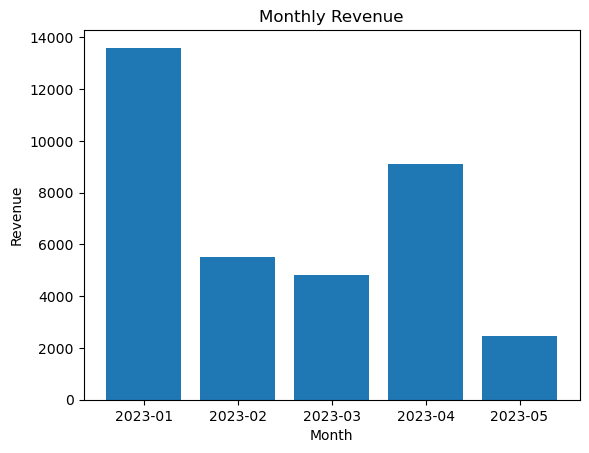

Total Revenue: 35490.0
Product with max revenue: P002
Date with max revenue: 2023-05-25


In [11]:
# Sample Generated Python Code ( Generated with Amazon Bedrock in previous step)

import csv
from collections import defaultdict
import matplotlib.pyplot as plt

revenue = 0
monthly_revenue = defaultdict(int)
product_revenue = defaultdict(int)
max_revenue = 0
max_revenue_date = ''
max_revenue_product = ''

with open('sales.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        date = row[0]
        product = row[1]
        price = float(row[2])
        units = int(row[3])

        revenue += price * units
        product_revenue[product] += price * units
        monthly_revenue[date[:7]] += price * units

        if revenue > max_revenue:
            max_revenue = revenue
            max_revenue_date = date
            max_revenue_product = product

months = list(monthly_revenue.keys())
values = list(monthly_revenue.values())

plt.bar(months, values)
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.title('Monthly Revenue')
plt.show()

print('Total Revenue:', revenue)
print('Product with max revenue:', max_revenue_product)
print('Date with max revenue:', max_revenue_date)